In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import h5py

import yaml
import os

ModuleNotFoundError: No module named 'h5py'

In [2]:


data_dir = "../DiarrheaExample/"
atlas_version = "v2.17"

# Load the YAML configuration file
with open("../atlas_output_files.yaml", 'r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.FullLoader)

# Access the specified version in the configuration
files = config[atlas_version]

# Function to update file paths in the nested dictionary
def update_paths(value, data_dir):
    if isinstance(value, str):
        return os.path.join(data_dir, value)
    elif isinstance(value, dict):
        return {key: update_paths(subvalue, data_dir) for key, subvalue in value.items()}

# Update file paths in the configuration
files = update_paths(files, data_dir)

# Access the "abundance_file" from the updated configuration
genecatalog_files = files["genecatalog"]
abundance_file = genecatalog_files["coverage"]


NameError: name 'h5py' is not defined

# Look at the gene stats

Let's have a look at the dimension of the data

In [6]:


# Open the HDF5 file
with h5py.File(abundance_file, 'r') as h5file:
    # Get the dimensions
    dim = h5file['dim'][:]
    Ngenes, Nsamples = dim

# Print the dimensions
print(f"The genecatalog contains {Ngenes} genes and {Nsamples} samples.")


KeyError: "Unable to synchronously open object (object 'dim' doesn't exist)"

Because the dimensions of the genecatalog are huge (even more so with more samples) but
many genes are detected only in a subset of samples,
I optimized the file format to allow for fast loading of a subset of the data.

However we still want information from all the genes.
The file `r genecatalog_files$sample_stats` contains stats per sample of the genecatalog.
Especially the number of genes that are detected in each sample and the total coverage which we will use for normalization.

Similarly the file `r gene_catalog_files$gene_stats` contains stats per gene, e.g. the number of samples in which the gene is detected.

Let's first look at the stats per sample.

### Gene stats per sample

/Users/silas/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/silas/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/silas/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/silas/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

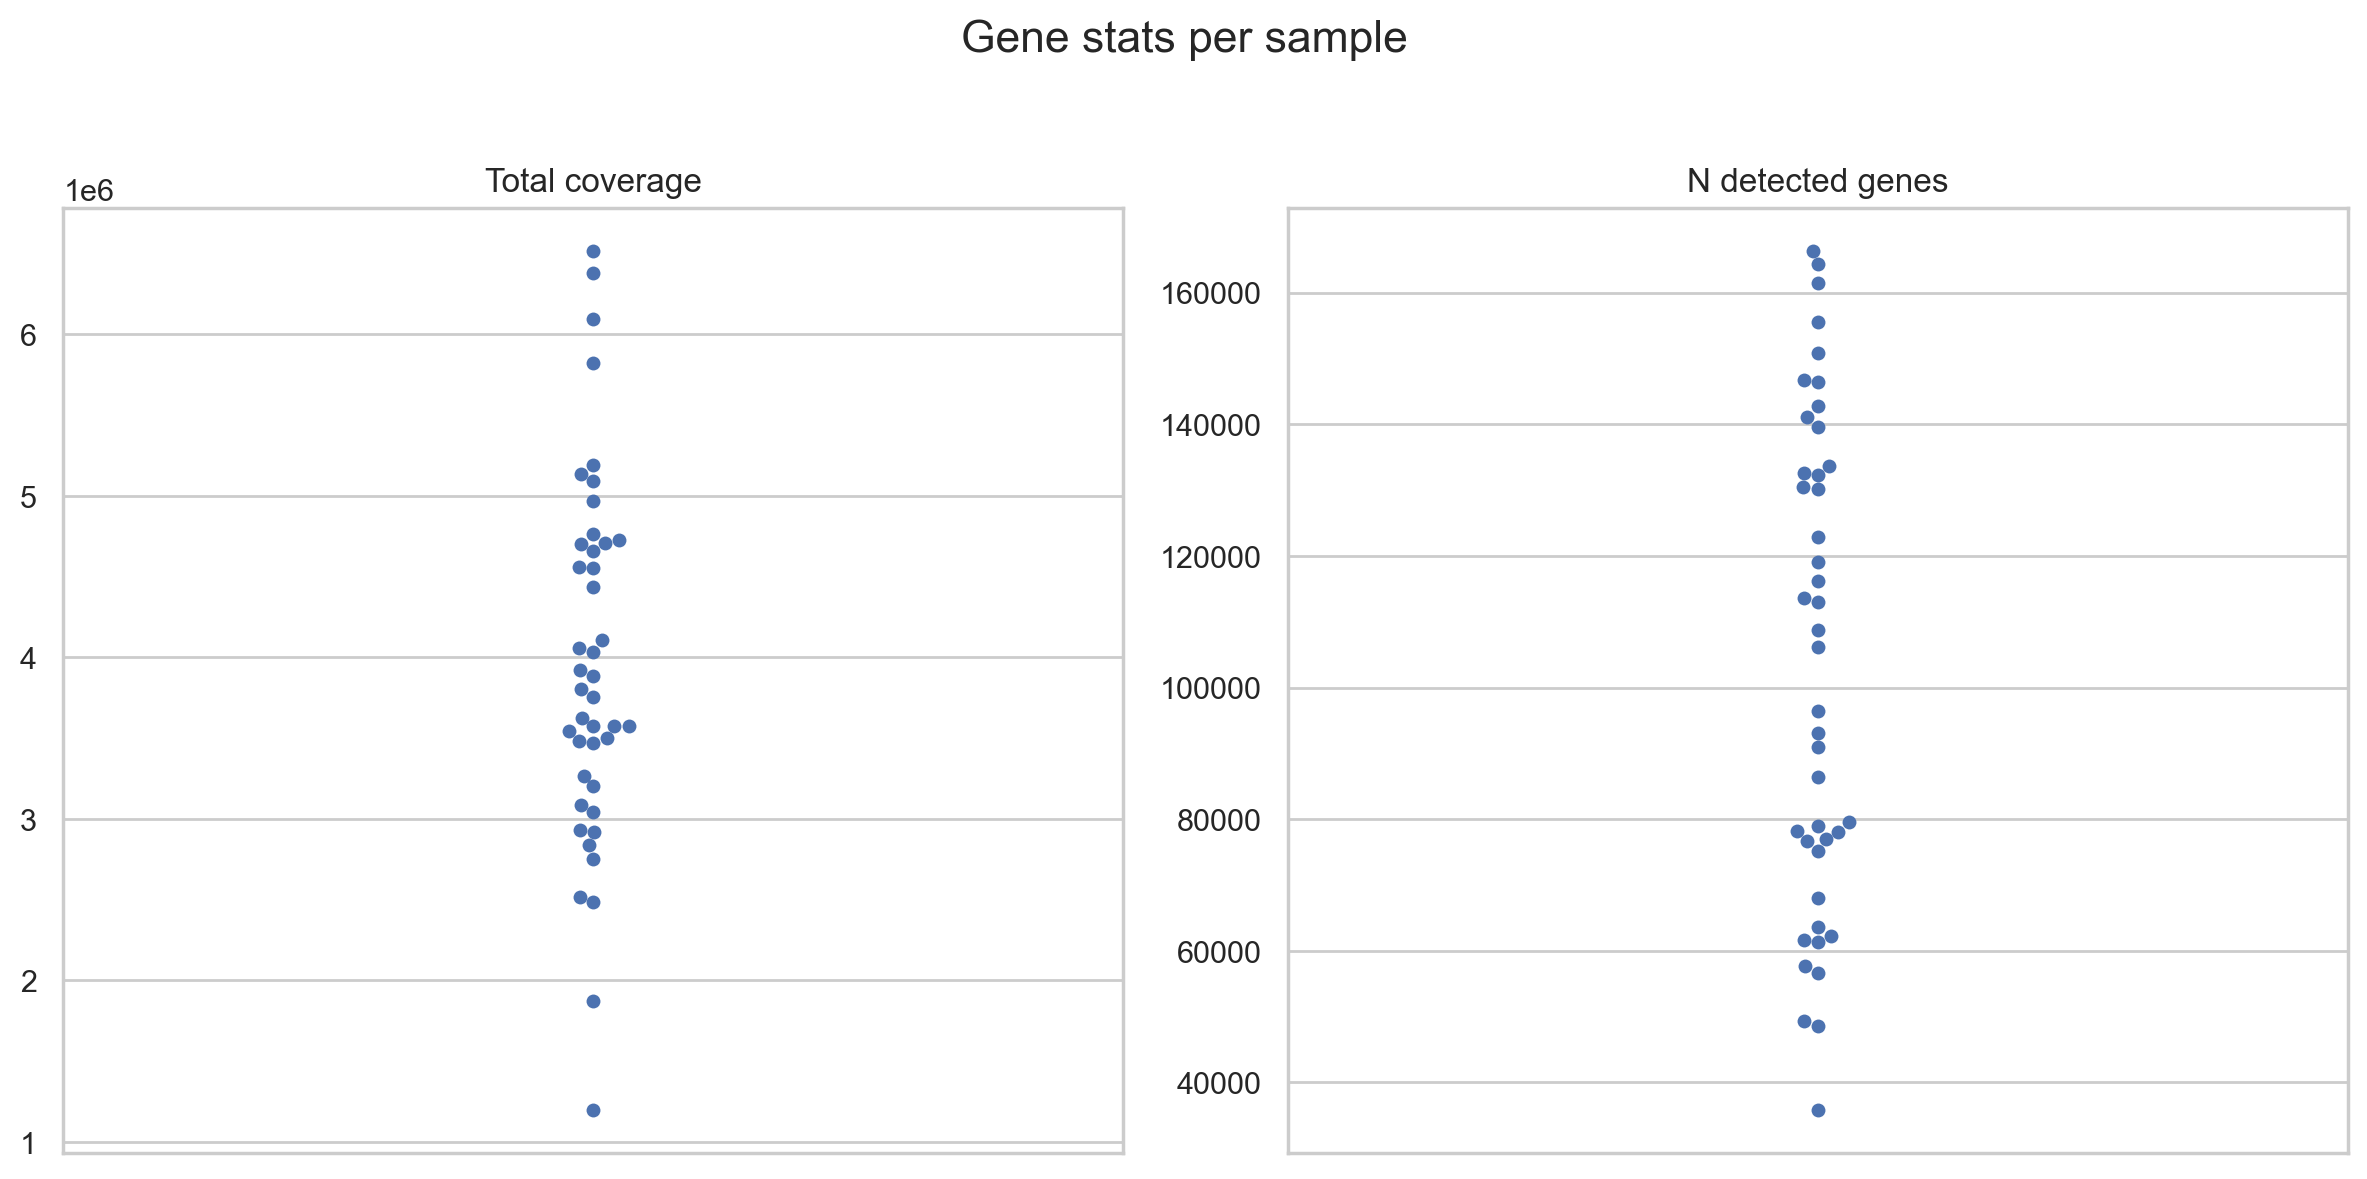

In [16]:
# Create a subplot with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot "Total coverage" on the first axis
sns.swarmplot(y="Sum_coverage", data=sample_stats, ax=axes[0])
axes[0].set_ylabel("",visible=False)
axes[0].set_title("Total coverage")

# Plot "N detected genes" on the second axis
sns.swarmplot(y="Genes_nz_coverage", data=sample_stats, ax=axes[1])
axes[1].set_ylabel("",visible=False)
axes[1].set_title("N detected genes")

# Set a common title for both axes
fig.suptitle("Gene stats per sample", fontsize=16)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


### Stats per gene


In [17]:

gene_stats_file = genecatalog_files["coverage_stats"]
gene_stats = pd.read_parquet(gene_stats_file)


gene_stats.head()


,GeneName,Length,GC,Samples_nz_coverage,Samples_nz_counts,Sum_coverage,Max_coverage
0,Gene000001,531,0.3861,17,30,2093,900
1,Gene000002,723,0.4716,10,19,399,94
2,Gene000003,951,0.5047,8,18,771,273
3,Gene000004,537,0.4646,5,8,50,22
4,Gene000005,405,0.5210,6,10,16,8


Samples_nz_coverage: Number of samples in which the gene has a non-zero coverage
Samples_nz_counts: Number of samples in which the gene has a non-zero counts
Sum_coverage: Sum of the coverage of the gene in all samples

The values for `Samples_nz_coverage` and `Samples_nz_counts` are not the same
because if there are only a view reads mapped to a gene but less than halve of the gene is covered the median coverage is zero.


In [20]:


# Create a histogram for log10(Sum_coverage)
plt.figure(figsize=(8, 4))
sns.histplot(gene_stats["Sum_coverage"], binwidth=0.2, color="blue", kde=True)
plt.title("Histogram of log10(Sum_coverage)")
plt.xlabel("log10(Sum_coverage)")
plt.ylabel("Frequency")
plt.show()

# Create a histogram for Samples_nz_coverage
plt.figure(figsize=(8, 4))
sns.histplot(gene_stats["Samples_nz_coverage"], binwidth=10, color="green", kde=True)
plt.title("Histogram of Samples_nz_coverage")
plt.xlabel("Samples_nz_coverage")
plt.ylabel("Frequency")
plt.show()


/Users/silas/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/silas/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyboardInterrupt: 